In [1]:
import numpy as np
import regression as reg
from scipy import io
from auxiliary_merge import m_DateList
import os, sys
from bma_merge import bma
from auxiliary_merge import extrapolation


# read from inputs
# time1 = int(sys.argv[1])
# time2 = int(sys.argv[2])
# print(time1,time2)

prefix = ['ERA5_', 'MERRA2_', 'JRA55_']

### Local Mac settings
# input files/paths
gmet_stnfile = '/Users/localuser/Research/EMDNA/basicinfo/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz'
file_mask = './DEM/NA_DEM_010deg_trim.mat'
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz' # near station of stations/grids
path_readowngrid = ['/Users/localuser/Research/EMDNA/downscale/ERA5',  # downscaled gridded data
                    '/Users/localuser/Research/EMDNA/downscale/MERRA2',
                    '/Users/localuser/Research/EMDNA/downscale/JRA55']
file_readownstn = ['/Users/localuser/Research/EMDNA/downscale/ERA5_downto_stn_nearest.npz', # downscaled to stn points
                   '/Users/localuser/Research/EMDNA/downscale/MERRA2_downto_stn_nearest.npz',
                   '/Users/localuser/Research/EMDNA/downscale/JRA55_downto_stn_nearest.npz']

# output files/paths (can also be used as inputs once generated)
near_path = '/Users/localuser/Research/EMDNA/correction'  # path to save near station for each grid/cell
path_ecdf = '/Users/localuser/Research/EMDNA/merge/ECDF'
path_pop = '/Users/localuser/Research/EMDNA/pop'
### Local Mac settings


# ### Plato settings
# gmet_stnfile = '/datastore/GLOBALWATER/CommonData/EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
# path_readowngrid = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds',  # downscaled gridded data
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds']
# file_readownstn = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds/ERA5_downto_stn_GWR.npz', # downscaled to stn points
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds/MERRA2_downto_stn_GWR.npz',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds/JRA55_downto_stn_GWR.npz']
# near_path = '/home/gut428/ReanalysisCorrMerge'  # path to save near station for each grid/cell
# path_ecdf = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/ECDF'
# path_pop = '/home/gut428/ReanalysisCorrMerge/pop'
# file_popmerge_stn = '/home/gut428/ReanalysisCorrMerge/pop/bmamerge_pop_stn.npz'
# ### Plato settings

near_stnfile = near_path + '/near_stn_prcp.npz'
near_gridfile = near_path + '/near_grid_prcp.npz'
file_reapop_stn = path_pop + '/reanalysis_pop_stn.npz'
file_popmerge_stn = path_pop + 'bmamerge_pop_stn.npz'


In [43]:
########################################################################################################################

# basic processing
print('start basic processing')

lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels

# meshed lat/lon of the target region
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)
lontarm[np.isnan(mask)] = np.nan
lattarm[np.isnan(mask)] = np.nan

# date list
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp['prcp_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

# load near station information
datatemp = np.load(near_file_GMET)
near_loc_stn = datatemp['near_stn_prcpLoc']
near_weight_stn = datatemp['near_stn_prcpWeight']
near_dist_stn = datatemp['near_stn_prcpDist']
near_loc_grid = datatemp['near_grid_prcpLoc']
near_weight_grid = datatemp['near_grid_prcpWeight']
near_dist_grid = datatemp['near_grid_prcpDist']
near_loc_grid = np.flipud(near_loc_grid)
near_weight_grid = np.flipud(near_weight_grid)
near_dist_grid = np.flipud(near_dist_grid)

# probability bins for QM
binprob = 500
ecdf_prob = np.arange(0, 1 + 1 / binprob, 1 / binprob)

########################################################################################################################

# load downscaled reanalysis at station points
print('load downscaled reanalysis data at station points')
readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    dr = np.load(file_readownstn[rr])
    temp = dr['prcp_readown']
    readata_stn[rr, :, :] = temp
    del dr, temp
readata_stn[readata_stn < 0] = 0


start basic processing
load downscaled reanalysis data at station points


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


In [3]:
# method-1: estimate pop using a univariate regression between station occurrence (0-1) and reanalysis precipitation
# file_popt = path_pop + '/reapop_stn_' + str(time1) + '-' + str(time2) + '.npz'
if os.path.isfile(file_reapop_stn):
    datatemp = np.load(file_reapop_stn)
    reapop_stn = datatemp['reapop_stn']
    del datatemp

In [5]:
    print('estimate bma merging weights for pop')
    bmaweight_stn = np.nan * np.zeros([12, nstn, reanum], dtype=np.float32)
    for m in range(12):
        print('month',m)
        indm = date_number['mm'] == (m+1)
        for i in range(nstn):
            if np.isnan(stndata[i, 0]):
                continue
            rea = reapop_stn[:, i, indm].T
            obs = stndata[i, indm].copy()
            obs[obs > 0] = 1
            weight, sigma, sigma_s = bma(rea, obs)
            bmaweight_stn[m, i, :] = weight

estimate bma merging weights for pop
month 0
month 1
month 2
month 3
month 4
month 5
month 6
month 7
month 8
month 9
month 10
month 11


In [24]:
    mergepop_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)
    for i in range(nstn):
        if np.mod(i,5000)==0:
            print(i)
        if np.isnan(stndata[i, 0]):
            continue
        nearloc = near_loc_stn[i, :]
        nearweight = near_weight_stn[i, :]
        nearweight = nearweight[nearloc > -1]
        nearweight = nearweight / np.sum(nearweight)
        nearloc = nearloc[nearloc > -1]
        nearweight = np.tile(nearweight,[reanum, 1]).T

        # get bma weight from nearby stations
        weight_i = np.zeros([12, reanum])
        for m in range(12):
            weight_im_near = bmaweight_stn[m, nearloc, :]
            weight_i[m, :] = np.sum(weight_im_near * nearweight, axis=0)

        # merging at the target station
        reapop_merge_i = np.zeros(ntimes)
        for m in range(12):
            indm = date_number['mm'] == (m + 1)
            reapop_stn_im = reapop_stn[:, i, indm]
            weight_im = np.tile(weight_i[m, :], [np.sum(indm), 1]).T
            weight_im[np.isnan(reapop_stn_im)] = np.nan
            reapop_merge_i[indm] = np.nansum(reapop_stn_im * weight_im, axis=0) / np.nansum(weight_im, axis=0)

        mergepop_stn[i, :] = reapop_merge_i


0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


5000
10000
15000
20000
25000


In [50]:
    # interpolate weights to grids
    bmaweight_grid  = np.nan * np.zeros([12, reanum, nrows, ncols], dtype=np.float32)
    for m in range(12):
        for rr in range(reanum):
            bmaweight_grid[m, rr, :, :] = extrapolation(bmaweight_stn[m, :, rr], near_loc_grid, near_dist_grid)

In [51]:
np.savez_compressed(file_popmerge_stn, bmaweight_stn=bmaweight_stn, bmaweight_grid=bmaweight_grid, mergepop_stn=mergepop_stn)

In [61]:
file='/Users/localuser/Downloads/weight.npz'
datatemp = np.load(file)
near_loc_grid2 = datatemp['near_grid_prcpLoc']
near_weight_grid2 = datatemp['near_grid_prcpWeight']
near_dist_grid2 = datatemp['near_grid_prcpDist']
near_loc_grid2 = np.flipud(near_loc_grid2)
near_weight_grid2 = np.flipud(near_weight_grid2)
near_dist_grid2 = np.flipud(near_dist_grid2)

In [125]:
file='/Users/localuser/Downloads/weight.npz'
datatemp = np.load(file)
near_loc_stn2 = datatemp['near_stn_prcpLoc']
near_weight_stn2 = datatemp['near_stn_prcpWeight']
near_dist_stn2 = datatemp['near_stn_prcpDist']
near_loc_grid2 = datatemp['near_grid_prcpLoc']
near_weight_grid2 = datatemp['near_grid_prcpWeight']
near_dist_grid2 = datatemp['near_grid_prcpDist']

datatemp = np.load(near_file_GMET)
near_loc_stn = datatemp['near_stn_prcpLoc']
near_weight_stn = datatemp['near_stn_prcpWeight']
near_dist_stn = datatemp['near_stn_prcpDist']
near_loc_grid = datatemp['near_grid_prcpLoc']
near_weight_grid = datatemp['near_grid_prcpWeight']
near_dist_grid = datatemp['near_grid_prcpDist']

In [80]:
file='/Users/localuser/Downloads/weight.npz'
datatemp = np.load(file)
near_loc_stn2 = datatemp['near_stn_tempLoc']
near_weight_stn2 = datatemp['near_stn_tempWeight']
near_dist_stn2 = datatemp['near_stn_tempDist']
near_loc_grid2 = datatemp['near_grid_tempLoc']
near_weight_grid2 = datatemp['near_grid_tempWeight']
near_dist_grid2 = datatemp['near_grid_tempDist']

datatemp = np.load(near_file_GMET)
near_loc_stn = datatemp['near_stn_tempLoc']
near_weight_stn = datatemp['near_stn_tempWeight']
near_dist_stn = datatemp['near_stn_tempDist']
near_loc_grid = datatemp['near_grid_tempLoc']
near_weight_grid = datatemp['near_grid_tempWeight']
near_dist_grid = datatemp['near_grid_tempDist']

In [126]:
np.sum(near_loc_stn2[:,0]>-1)

24716

In [127]:
np.sum(near_loc_stn[:,0]>-1)

24716

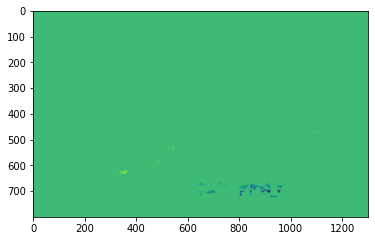

In [124]:
plt.imshow(diff[:,:,10])

In [81]:
        file_reapop = path_pop + '/rea_pop_' + str(y * 100 + m + 1) + '.npz'
        file_bmapop = path_pop + '/bmamerge_pop_' + str(y * 100 + m + 1) + '.npz'

In [82]:
        # date processing
        indmy = (date_number['yyyy'] == y) & (date_number['mm'] == m + 1)
        mmdays = np.sum(indmy)

        # read raw gridded reanalysis data
        readata_raw = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)


In [83]:
        for rr in range(reanum):
            if not (prefix[rr] == 'MERRA2_' and y == 1979):
                filer = path_readowngrid[rr] + '/' + prefix[rr] + 'ds_prcp_' + str(y*100 +m+1) + '.npz'
                d = np.load(filer)
                readata_raw[rr, :, :, :] = d['data']
                del d

In [87]:
            reapop_grid = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)
            for r in range(nrows):
                print(r, nrows)
                for c in range(ncols):
                    if np.isnan(mask[r, c]):
                        continue
                    nearloc = near_loc_grid[r, c, :]
                    neardist = near_dist_grid[r, c, :]
                    nearweight = near_weight_grid[r, c, :]
                    neardist = neardist[nearloc > -1]
                    nearweight = nearweight[nearloc > -1]
                    nearweight = nearweight / np.sum(nearweight)
                    nearloc = nearloc[nearloc > -1]

                    nstn_prcp = len(nearloc)
                    w_pcp_red = np.zeros([nstn_prcp, nstn_prcp])
                    for i in range(nstn_prcp):
                        w_pcp_red[i, i] = nearweight[i]  # eye matrix: stn weight in one-one lien

                    x_red = np.ones([nstn_prcp, 2])
                    for rr in range(reanum):
                        for tt in range(mmdays):
                            prea_tar = readata_raw[rr, r, c, tt]
                            prea_near = readata_stn[rr, nearloc, tt]
                            pstn_near = stndata[nearloc, tt]
                            pstn_near[pstn_near > 0] = 1

                            # logistic regression
                            if np.all(pstn_near == 1):
                                reapop_grid[rr, r, c, tt] = 1
                            elif np.all(pstn_near == 0) or np.all(prea_near < 0.01):
                                reapop_grid[rr, r, c, tt] = 0
                            else:
                                x_red[:, 1] = prea_near
                                tx_red = np.transpose(x_red)
                                twx_red = np.matmul(tx_red, w_pcp_red)
                                b = reg.logistic_regression(x_red, twx_red, pstn_near)
                                if np.all(b == 0) or np.any(np.isnan(b)):
                                    reapop_grid[rr, r, c, tt] = np.dot(nearweight, pstn_near)
                                else:
                                    zb = - np.dot(np.array([1, prea_tar]), b)
                                    reapop_grid[rr, r, c, tt] = 1 / (1 + np.exp(zb))

0 800
1 800
2 800
3 800
4 800
5 800
6 800
7 800
8 800
9 800
10 800
11 800
12 800
13 800
14 800
15 800
16 800
17 800
18 800


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/Users/localuser/Github/PyGMET/regression.py:44: RuntimeWarning: invalid value encountered in greater
  if np.any(xb > 50):
/Users/localuser/Github/PyGMET/regression.py:50: RuntimeWarning: invalid value encountered in greater
  if np.any(p > 0.9999):
/usr/local/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/localuser/Github/PyGMET/regression.py:62: RuntimeWarning: invalid value encountered in greater
  if np.any(np.abs(bn) > 1e-4):


19 800
20 800
21 800
22 800
23 800
24 800
25 800
26 800


KeyboardInterrupt: 

In [96]:
            # initialization
            bma_data = np.nan * np.zeros([nrows, ncols, mmdays], dtype=np.float32)

            # (1) estimate the error of corrected data by interpolating stations
            obs = stndata[:, indmy].copy()
            obs[obs>0]=1
            bma_error = extrapolation(mergepop_stn[:, indmy] - obs, near_loc_grid, near_dist_grid)

            # (2) estimate the value of merged data
            reamerge_weight_gridm = bmaweight_grid[m, :, :, :].copy()
            for i in range(mmdays):
                datai = reapop_grid[:, :, :, i]
                weighti = reamerge_weight_gridm.copy()
                weighti[np.isnan(datai)] = np.nan
                bma_data[:, :, i] = np.nansum(weighti * datai, axis=0) / np.nansum(weighti, axis=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [128]:
datatemp = np.load(gmet_stndatafile)
stndata = datatemp['prcp_stn']
stnlle = datatemp['stn_lle']

In [133]:
zz=np.zeros(nstn)
for i in range(nstn):
    zz[i]=len(np.unique(stndata[i]))

In [138]:
np.sum(np.isnan(stndata[:,14600]))

2693